# (1.1) Load Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize

In [2]:
from collections import namedtuple
from collections import defaultdict

Dataset = namedtuple('Dataset', 'name, train, test')
Model = namedtuple('Model', 'type, name, dimension, corpus, model')

In [3]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 200)
MAIN_PATH_DATASET = "../cwishareddataset/traindevset/english/"
genres = ['Wikipedia', 'WikiNews', 'News']
datasets = ['Train', 'Dev']
columns = ['id', 'sentence', "start", "end", "target", 
           "nat", "non_nat", "nat_marked", "non_nat_marked", "binary", "prob"]


datasets = [Dataset('Wikipedia', 'Train', 'Dev'),
            Dataset('WikiNews', 'Train', 'Dev'),
            Dataset('News', 'Train', 'Dev')]

feature_categories = []

def load_df(path):
    df = pd.read_csv(path, header=None, sep = "\t")
    df.columns = columns
    return df

datasets = [Dataset(d.name, load_df(MAIN_PATH_DATASET + d.name + '_' + d.train + '.tsv'),
                            load_df(MAIN_PATH_DATASET + d.name + '_' + d.test + '.tsv'))
                            for d in datasets]

# (1.2) Load Embedding Models

In [4]:
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

MAIN_PATH = 'D:/workspace_python/CoWoReId/python/resources/word-embeddings/'

glove_defs = [#Model('glove', 'glove.42B.300d.txt', 300, 'cc42B', None),  
              #Model('glove', 'glove.840B.300d.txt', 300, 'cc840B', None), 
              Model('glove', 'glove.6B.50d.txt', 50, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.100d.txt',100, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.6B.200d.txt', 200, 'wikipedia+gigaword5', None), 
              #Model('glove', 'glove.6B.300d.txt', 300, 'wikipedia+gigaword5', None),
              #Model('glove', 'glove.twitter.27B.25d.txt', 25, 'twitter', None)]
              Model('glove', 'glove.twitter.27B.50d.txt', 50, 'twitter', None)] 
              #Model('glove', 'glove.twitter.27B.100d.txt', 100, 'twitter', None), 
              #Model('glove', 'glove.twitter.27B.200d.txt', 200, 'twitter', None)]

glove_models = []
for model in glove_defs:
    glove_file = datapath(MAIN_PATH + model.name)
    tmp_file = get_tmpfile(model.name + '-temp')
    glove2word2vec(glove_file, tmp_file)
    vecs = KeyedVectors.load_word2vec_format(tmp_file)
    glove_models.append(Model(model.type, model.name, model.dimension, model.corpus, vecs))
    print('load model : {}'.format(model.name))
    
print(glove_models)

C:\Users\Studio\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


load model : glove.6B.50d.txt
load model : glove.twitter.27B.50d.txt
[Model(type='glove', name='glove.6B.50d.txt', dimension=50, corpus='wikipedia+gigaword5', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000007EE1F77358>), Model(type='glove', name='glove.twitter.27B.50d.txt', dimension=50, corpus='twitter', model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x0000007EEF61D7B8>)]


In [11]:
models = []
models.extend(glove_models)

# (2.1) Preprocessing
Here we present all the code to preprocess the data stored in a dataframe into a proper representation that can be used in sequence tagging models.

In [35]:
from nltk import word_tokenize
from functools import lru_cache
from utils import penn_to_wn
import re
import unicodedata
import sys
from collections import Counter
from ngram_representation import missing_strat_random

def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

tbl = dict.fromkeys(i for i in range(sys.maxunicode)
                      if unicodedata.category(chr(i)).startswith('P'))

def remove_punctuation(text):
    return text.translate(tbl)

@lru_cache(maxsize=None)
def all_tokens_with_index(context):
    '''
    Receives a sentence denoted by context and applies tokenization
    on the input. Each token is annotated with its word index starting
    from 1 and the corresponding start and end character positions of 
    the word. Also applies some strategies to handle unproper formated
    input sentence string such as removing additional whitespaces and 
    quotation marks that otherwise change the actual character start
    and end positions. All results are cached in case it has to be computed
    multiple times for the same sentence.
    '''
    curr_pos = 0
    targets = []
    j = 0
    w = 0
    curr_split = ''
    ctx_split = context.split()
    whitespaces = re.findall('\s+', context)
    num_whitespaces = [len(token) for token in whitespaces]
    num_whitespaces.append(1)
    tokens = word_tokenize(context)
    tokens = ['"' if token not in context else token for token in tokens]
    for index, token in enumerate(tokens, 1):
        targets.append((token, index, curr_pos, (curr_pos + len(token))))
        curr_pos += len(token)
        curr_split += token
        if ctx_split[j] == curr_split:
            curr_pos += num_whitespaces[w]
            j += 1
            w += 1
            curr_split = ''
    return [val for val in targets if val[0] != '"']

def build_vocabulary(sentences, embedding, dimension, 
                     missing='unique', provided = ['s_target', 'e_target']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a vocabulary of the words contained
    and assigns unique indicies to the words. In particular, it returns 
    a map of indices to their words, a map of words to their indices
    and based on the provided embedding model an embedding matrix
    for the constructed vocabulary. For missing vocabulary, it 
    constructs a random embedding and a proper index is missing parameter
    is set to 'unique', otherwise if it is set to 'equal' it creates
    a random embedding for one special UNK embedding and neglects missing
    vocabulary in the built index. All tokens in the 'provided' list,
    receive under 'equal' mode still individual random embeddings.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_words = [word for sentence in sentences for word in sentence]
    print('# Words : {}'.format(len(all_words)))
    counter = Counter(all_words)
    index = 1
    word2index = {}
    for (word, count) in counter.most_common():
        if (missing=='unique' or word in embedding.vocab):
            word2index[word] = index
            index += 1
    word2index['_pad_'] = 0
    if missing == 'equal':
        word2index['_unk_'] = len(word2index)
        for token in provided:
            word2index[token] = len(word2index)
    index2word = {index : word for word, index in word2index.items()}
    vocab_size = len(word2index)
    print('# Vocab : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_words = []
    for word, index in word2index.items():
        if word in embedding.vocab:
            embedding_matrix[index] = embedding[word]
        else:
            embedding_matrix[index] = missing_strat_random(word, dimension)
            missing_embed_words.append(word)
    missing_embed_count = len(missing_embed_words)
    print('# Words missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return word2index, index2word, embedding_matrix


def build_char_vocabulary(sentences, embedding, dimension, 
                          missing='unique', provided = ['_']):
    '''
    Based on a list of sentences which are themselve represented
    as a list of words, constructs a character vocabulary and provides
    a mapping of unique indices to the found characters, a mapping of
    the characters to their indicies and a character embedding matrix
    where the i-th row represents the character embedding of the character
    with index i. This is based on a provided character embedding, represented
    as a dictionary. Provided tokens will be added as a single char to
    the vocabulary.
    '''
    if missing not in ['unique', 'equal']:
        raise ValueError("Parameter missing must be either 'equal' or 'unique'")
    all_chars = [char for sentence in sentences 
                 for word in sentence for char in word]
    all_chars.extend(provided)
    print('# Chars : {}'.format(len(all_chars)))
    counter = Counter(all_chars)
    index = 1
    char2index = {}
    for (char, count) in counter.most_common():
        if (missing=='unique' or char in embedding.keys()):
            char2index[char] = index
            index += 1
    char2index['_pad_'] = 0
    if missing == 'equal':
        char2index['_unk_'] = len(char2index)
    index2char = {index : char for char, index in char2index.items()}
    vocab_size = len(char2index)
    print('# Vocab (chars) : {}'.format(vocab_size))
    embedding_matrix = np.zeros(((vocab_size), dimension))
    embedding_matrix[0] = missing_strat_random('_pad_', dimension)
    missing_embed_chars = []
    for char, index in char2index.items():
        if char in embedding.keys():
            embedding_matrix[index] = embedding[char]
        else:
            embedding_matrix[index] = missing_strat_random(char, dimension)
            missing_embed_chars.append(char)
    missing_embed_count = len(missing_embed_chars)
    print('# Chars missing embedding : {}'.format(missing_embed_count))
    print('Embedding shape : {}'.format(embedding_matrix.shape))
    return char2index, index2char, embedding_matrix


def compute_character_embeddings(embedding):
    '''
    Computes a character embedding as a dictionary of word to its
    embedding based on a gensim word embedding. For each character,
    averages the word embeddings containing the character as an
    approximation to character-level embeddings.
    '''
    chars = {}
    for word, vocab in embedding.vocab.items():
        vector = embedding[word]
        for char in word:
            if ord(char)<128:
                if char in chars:
                    chars[char] = (chars[char][0]+vector, 
                                   chars[char][1]+1)
                else:
                    chars[char] = (vector, 1)
    for char, (vector, num) in chars.items():
        chars[char] = np.round(vector/num, 6).tolist()
    return chars

def forward_transformation(dataframe, lowercase = True, filter_punc = True, filtering = "a132"):
    grouped = dataframe.groupby('sentence').apply(lambda row : 
                        {'sent_id' : list(set(row['sent_id']))[0],
                         'sentence' : list(set(row['sentence']))[0], 
                         'tags': [tag for tag in zip(row['target'], 
                            row['start'], row['end'], row['binary'], row['prob'])]})
    sentences = []
    for vals in grouped:
        sent_id = vals['sent_id']
        sentence = vals['sentence']
        tags = vals['tags']
        tags_without_labels = [(word, start, end) for word, start, end, binary, prob in tags]
        all_tokens = all_tokens_with_index(sentence)
        sent_repr = [(word, start, end, tags[tags_without_labels.index((word, start, end))][3],
                     tags[tags_without_labels.index((word, start, end))][4])
           if (word, start, end) in tags_without_labels 
          else (word, start, end, 0, 0.0) for word, index, start, end in all_tokens]
        if lowercase:
            sent_repr = [(word.lower(), start, end, binary, prob) 
                         for word, start, end, binary, prob in sent_repr]
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append({'sent_id' : sent_id, 'sentence' : sentence, 'seq' : sent_repr})
    return sentences

def split_sentence_seqs(sentences):
    words, start_end, binary, prob = [], [], [] ,[]
    for sent in sentences:
        sequence = sent['seq']
        curr_w, curr_se, curr_b, curr_p = map(list, zip(*[(vals[0], 
            (vals[1], vals[2]), vals[3], vals[4]) for vals in sequence]))
        words.append(curr_w)
        start_end.append(curr_se)
        binary.append(curr_b)
        prob.append(curr_p)
    return words, start_end, binary, prob

def forward_transformation_be_tags(dataframe, start_tag = 's_target', end_tag = 'e_target',
                                   lowercase = True, filter_punc = True, filtering = "a132"):
    sentences = []
    binaries = []
    probabilities = []
    for index, row in dataframe.iterrows():
        sentence = row['sentence']
        start = row['start']
        end = row['end']
        sentence = sentence[:start] + start_tag + ' ' + sentence[start:end] + \
                             ' ' + end_tag + sentence[end:]
        if lowercase:
            sentence = sentence.lower()
        sent_repr = all_tokens_with_index(sentence)
        if filter_punc:
            sent_repr = list(filter(lambda vals : remove_punctuation(vals[0]), sent_repr))
        if filtering:
            sent_repr = list(filter(lambda vals : vals[0] != "'s", sent_repr))
            sent_repr = list(filter(lambda vals : vals[0] != "``", sent_repr))
        sentences.append([word for word, index, start, end in sent_repr])
        binaries.append(row['binary'])
        probabilities.append(row['prob'])
    return (sentences, binaries, probabilities)

In [21]:
word_embedding = models[0].model
char_embeddings = compute_character_embeddings(word_embedding)

In [36]:
dimension = word_embedding.vector_size
char2index, index2char, char_embedding = build_char_vocabulary(sentences, char_embeddings, dimension, missing='equal')

# Chars : 963941
# Vocab (chars) : 48
# Chars missing embedding : 2
Embedding shape : (48, 50)


In [37]:
char2index.keys()

dict_keys(['e', 't', 'a', 'r', 'i', 'n', 's', 'o', 'h', 'l', 'd', 'c', 'g', 'u', 'm', 'f', 'p', 'b', 'w', '_', 'y', 'v', 'k', '0', '1', '-', '9', '2', 'x', 'j', '4', 'q', '6', '8', 'z', '3', '5', '7', '.', ',', '`', "'", '\\', '/', '=', '~', '_pad_', '_unk_'])

In [17]:
embedding = models[0].model
dimension = embedding.vector_size
word2index, index2word, word_embedding = build_vocabulary(sentences, embedding, dimension, missing='unique')

# Words : 186472
# Vocab : 3641
# Words missing embedding : 162
Embedding shape : (3641, 50)


In [8]:
datasets.append(Dataset('train_all_test_wiki', 
        datasets[0].train.append(datasets[1].train).append(datasets[2].train), datasets[0].test))

In [12]:
# Append train and test set
dataset_sel = datasets[0]
train_num_rows = dataset_sel.train.shape[0]
train_num_sents = len(list(set(dataset_sel.train.sentence.values.tolist())))

test_num_rows = dataset_sel.test.shape[0]
test_num_sents = len(list(set(dataset_sel.test.sentence.values.tolist())))

dataset = dataset_sel.train.append(dataset_sel.test)
dataset['sent_id'] = dataset.groupby('sentence').ngroup()
dataset_num_rows = dataset.shape[0]
dataset_num_sents = len(list(set(dataset.sentence.values.tolist())))

print('# Rows train : {}'.format(train_num_rows))
print('# Rows test : {}'.format(test_num_rows))
print('# Rows dataset : {}'.format(dataset_num_rows))

print('# Sents train : {}'.format(train_num_sents))
print('# Sents test : {}'.format(test_num_sents))
print('# Sents dataset : {}'.format(dataset_num_sents))

# Rows train : 5551
# Rows test : 694
# Rows dataset : 6245
# Sents train : 387
# Sents test : 53
# Sents dataset : 440


In [13]:
sentences, binary, prob = forward_transformation_be_tags(dataset)
train_sentences = sentences[:train_num_rows]
test_sentences = sentences[train_num_rows:]

In [104]:
sentence_lens = [len(sent) for sent in sentences]

Sentence lengths


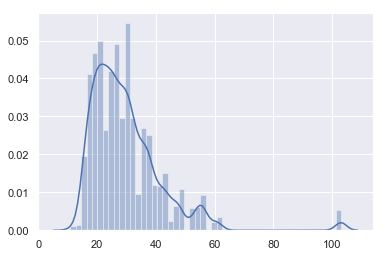

In [105]:
import seaborn as sns, numpy as np
import matplotlib.pyplot as plt
sns.set()
ax = sns.distplot(sentence_lens)
print('Sentence lengths')
plt.show()

In [453]:
figure = ax.get_figure()
figure.savefig('../plots/dl/sentence_length_dist.pdf')

In [106]:
embedding_model = models[0].model
dimension = embedding_model.vector_size
word2index, index2word, embedding = build_vocabulary(sentences, embedding_model, dimension)

# Words : 186472
# Vocab : 3641
# Words missing embedding : 161
Embedding shape : (3641, 50)


In [107]:
words_with_indices = [[word2index[word] for word in sent] for sent in sentences]

In [114]:
sent_lens = [len(sentence) for sentence in sentences]
sent_max_length = np.max(sent_lens)
print('Max length sentence : {}'.format(sent_max_length))

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

words_padded = pad_sequences(maxlen=sent_max_length, sequences=words_with_indices, padding="post", value=0)

binary_padded_categorical = [to_categorical(clazz, num_classes=2) for clazz in binary]

Max length sentence : 103


Using TensorFlow backend.


In [122]:
# Split the previously combined train and test set

# (1) Training set
train_words_padded = words_padded[:train_num_rows]
train_binary_padded_categorical = binary_padded_categorical[:train_num_rows]

# (2) Test set
test_words_padded = words_padded[train_num_rows:]
test_binary_padded_categorical = binary_padded_categorical[train_num_rows:]

print('Training set length : {}'.format(len(train_words_padded)))
print('Test set length : {}'.format(len(test_words_padded)))

Training set length : 5551
Test set length : 694


In [137]:
from sklearn.metrics import f1_score
import keras.callbacks

class Metrics(keras.callbacks.Callback):
    def __init__(self):
        self.f1_scores = []
        
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0]))
        targ = self.validation_data[1]
        targ = np.array(targ)
        targ = np.argmax(targ, axis = 1)
        predict = np.argmax(predict, axis = 1)
        self.f1s=f1_score(targ, predict)
        print(f1_score(targ, np.ones(targ.shape[0])))
        print(targ.shape)
        print(predict.shape)
        print('--------------------Targets-------------------------')
        print(self.f1s)
        self.f1_scores.append(self.f1s)
        print(targ)
        print('--------------------Predictions-------------------------')
        print(predict)
        return

In [129]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [195]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

vocab_size = embedding.shape[0]
dimension = embedding.shape[1]

np.set_printoptions(threshold=np.inf)

in_seq = Input(shape=(sent_max_length,))
embed = Embedding(input_dim=vocab_size, output_dim=dimension, \
                  weights=[embedding], input_length=sent_max_length)(in_seq)
drop = Dropout(0.1)(embed)
lstm = Bidirectional(LSTM(units=150, return_sequences=False, recurrent_dropout=0.1))(drop)
out = Dense(2, activation="softmax")(lstm)

model = Model(in_seq, out)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()

metrics = Metrics()
history = model.fit(train_words_padded, np.array(train_binary_padded_categorical), batch_size=1, 
                    epochs=2, validation_data = (test_words_padded, np.array(test_binary_padded_categorical)), 
                    verbose=1, callbacks=[metrics])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 103)               0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 103, 50)           182050    
_________________________________________________________________
dropout_12 (Dropout)         (None, 103, 50)           0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 300)               241200    
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 602       
Total params: 423,852
Trainable params: 423,852
Non-trainable params: 0
_________________________________________________________________
Train on 5551 samples, validate on 694 samples
Epoch 1/2
5551/5551 [==============================] - 912s 164ms/step - loss: 0.6876 - a

In [196]:
len(metrics.f1_scores)

2

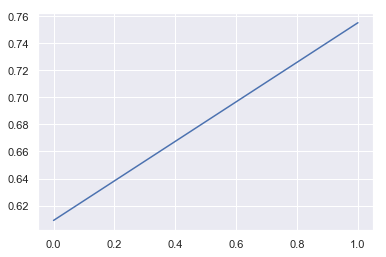

In [197]:
sns.set_style("darkgrid")
epoch_f1s = plt.plot(metrics.f1_scores)
plt.show()

In [198]:
predictions = model.predict(test_words_padded)
predictions.shape

(694, 2)

In [189]:
final_predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [199]:
final_predictions = np.argmax(predictions, axis = 1)

In [200]:
len(final_predictions)

694

In [201]:
targets = np.argmax(test_binary_padded_categorical, axis = 1)

In [202]:
len(targets)

694

In [203]:
f1_score(targets, final_predictions)

0.7551546391752577

In [148]:
def overlaps(start1, end1, start2, end2):
    return bool(range(max(start1, start2), min(end1, end2)+1))

def ngram_prediction_agg_majority_vote(predictions):
    positive_sum = np.sum(predictions)
    ratio = positive_sum / len(predictions)
    return int(ratio + 0.5)

def ngram_prediction_agg_max(predictions):
    return np.max(predictions)

def ngram_prediction_agg_begin(predictions):
    return predictions[0]

def ngram_prediction_agg_end(predictions):
    return predictions[-1]

ngram_prediction_agg = ngram_prediction_agg_max
results = []
dataframe = dataset
num_missing_match = []
all_predictions = []
all_labels = []
count=0
sent_count = 0
for ind, sent in enumerate(test_words_padded):
    sentence = test_sentences[ind]['sentence']
    sent_id = test_sentences[ind]['sent_id']
    words = [index2word.get(index, 'pad')  for index in sent]
    print(sentence)
    print(sent_id)
    print(words)
    ses = test_start_end[ind]
    preds = final_predictions[ind]
    print(ses)
    print(preds)
    selected = dataframe.loc[dataframe.sent_id==sent_id,]
    targets = selected.target.values.tolist()
    start_ends = list(zip(selected.start.values.tolist(), selected.end.values.tolist()))
    binary_y = selected.binary.values.tolist()
    print(binary_y)
    print(targets)
    print(start_ends)
    for label_index,(start, end) in enumerate(start_ends):
        print('-----',start, end)
        matching_indices = [i for i, (s, e) in enumerate(ses) if overlaps(start, end, s, e)]
        if not matching_indices:
            num_missing_match.append((sentence, sent_id, (start,end), ses, words))
            prediction = 0
        matching_predictions = [preds[i] for i in matching_indices]
        if len(matching_predictions)>1:
            prediction = ngram_prediction_agg(matching_predictions)
        else:
            if matching_indices:
                prediction = matching_predictions[0]
        matching_labels = binary_y[label_index]
        print(matching_indices)
        print(matching_labels)
        print(matching_predictions)
        print(prediction)
        all_labels.append(matching_labels)
        all_predictions.append(prediction)


TypeError: list indices must be integers or slices, not str

In [811]:
f1_score(all_labels, all_predictions)

0.7076271186440678

In [691]:
len(all_labels)


707

In [637]:
dataset.loc[dataset.sent_id==387,]

,id,sentence,start,end,target,nat,non_nat,nat_marked,non_nat_marked,binary,prob,sent_id
226,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",4,14,zero point,10,10,1,0,1,0.05,387
227,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",22,35,thermodynamic,10,10,2,2,1,0.20,387
228,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",9,14,point,10,10,0,0,0,0.00,387
229,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",36,47,temperature,10,10,2,0,1,0.10,387
230,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",36,53,temperature scale,10,10,1,0,1,0.05,387
231,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",48,53,scale,10,10,1,1,1,0.10,387
232,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",64,70,Kelvin,10,10,2,0,1,0.10,387
233,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",74,81,Rankine,10,10,2,0,1,0.10,387
234,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",94,102,absolute,10,10,0,0,0,0.00,387
235,3KVQ0UJWPXMUWB3UPVC6XSKX54H5WE,"The zero point of any thermodynamic temperature scale , such as Kelvin or Rankine , is set at absolute zero .",87,90,set,10,10,0,0,0,0.00,387
